In [181]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

plt.style.use("seaborn-v0_8")
%matplotlib inline  


# Load data

In [71]:
# get table names
path = '../data/'
files = os.listdir(path)
csv_files = [file for file in files if file.endswith('.csv')]
table_names = [file.split('.')[0] for file in csv_files]
table_names

['assessments',
 'courses',
 'studentAssessment',
 'studentInfo',
 'studentRegistration',
 'studentVle',
 'vle']

In [72]:
# create dict of DataFrames for each table 
dfs = {}

for table_name in table_names:
    dfs[f'{table_name}'] = pd.read_csv(f'{path}{table_name}.csv')

print("SIZE OF TABLES \n")

for table_name, df in dfs.items():
    print(table_name, df.shape)

SIZE OF TABLES 

assessments (206, 6)
courses (22, 3)
studentAssessment (173912, 5)
studentInfo (32593, 12)
studentRegistration (32593, 5)
studentVle (10655280, 6)
vle (6364, 6)


In [73]:
# look at column names
for table_name, df in dfs.items():
    print(table_name, '\n', df.columns.values, '\n')

assessments 
 ['code_module' 'code_presentation' 'id_assessment' 'assessment_type'
 'date' 'weight'] 

courses 
 ['code_module' 'code_presentation' 'module_presentation_length'] 

studentAssessment 
 ['id_assessment' 'id_student' 'date_submitted' 'is_banked' 'score'] 

studentInfo 
 ['code_module' 'code_presentation' 'id_student' 'gender' 'region'
 'highest_education' 'imd_band' 'age_band' 'num_of_prev_attempts'
 'studied_credits' 'disability' 'final_result'] 

studentRegistration 
 ['code_module' 'code_presentation' 'id_student' 'date_registration'
 'date_unregistration'] 

studentVle 
 ['code_module' 'code_presentation' 'id_student' 'id_site' 'date'
 'sum_click'] 

vle 
 ['id_site' 'code_module' 'code_presentation' 'activity_type' 'week_from'
 'week_to'] 



# Inspect individual tables
We will take a first look at each table using the function below. We'll delve a bit deeper where we see fit.

In [74]:
def first_inspection(table_name):
    df = dfs[table_name].copy()
    print(f"Table '{table_name}':\n")
    print(f"Head:\n{df.head()}\n")
    print(f"Info:")
    print(f"{df.info()}\n")
    print(f"Percentage missing data:\n{df.isna().sum()/len(df)}\n")
    print(f"Number of duplicate rows:\n{df.duplicated().sum()}\n")
    try:
        print(f"Overview numeric columns:\n{df.describe()}\n")
    except:
        print("Failed to print overview of numeric columns. Possibly there are no numeric columns.")
    try:
        print(f"Overview categorical columns:\n{df.describe(include='object')}\n")
    except:
        print("Failed to print overview of categorical columns. Possibly there are no categorical columns.")

    return df

## courses

code_module – code name of the module, which serves as the identifier.

code_presentation – code name of the presentation. It consists of the year and “B” for the presentation starting in February and “J” for the presentation starting in October.

length - length of the module-presentation in days.

In [75]:
df_courses = first_inspection('courses')

Table 'courses':

Head:
  code_module code_presentation  module_presentation_length
0         AAA             2013J                         268
1         AAA             2014J                         269
2         BBB             2013J                         268
3         BBB             2014J                         262
4         BBB             2013B                         240

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes
None

Percentage missing data:
code_module                   0.0
code_presentation             0.0
module_presentation_length    0.0
dtype: float64

Number of duplicate row

code_module is mentioned as identifier, but contains duplicates. We will check whether the combination between code_module and code_presentation provides a unique identifier.

In [76]:
df_courses[['code_module', 'code_presentation']].duplicated().sum()

np.int64(0)

We will take a look at the distribution of module_presentation_length

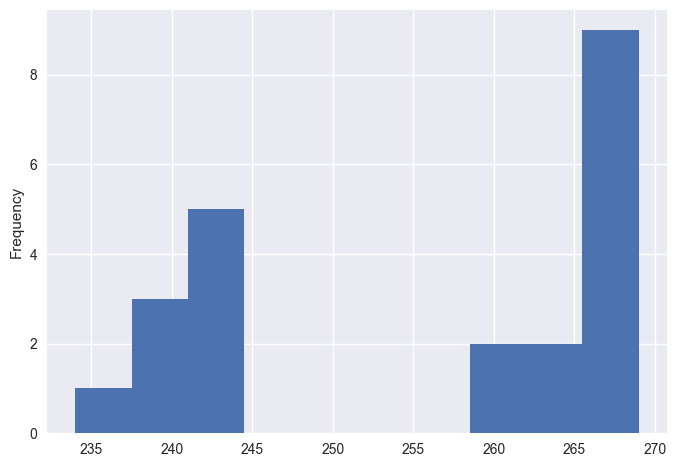

In [77]:
df_courses['module_presentation_length'].plot.hist();

Two groups of courses are clearly visible based on the module_presentation_length. We'll visually inspect how they are related based on code_module and code_presentation.

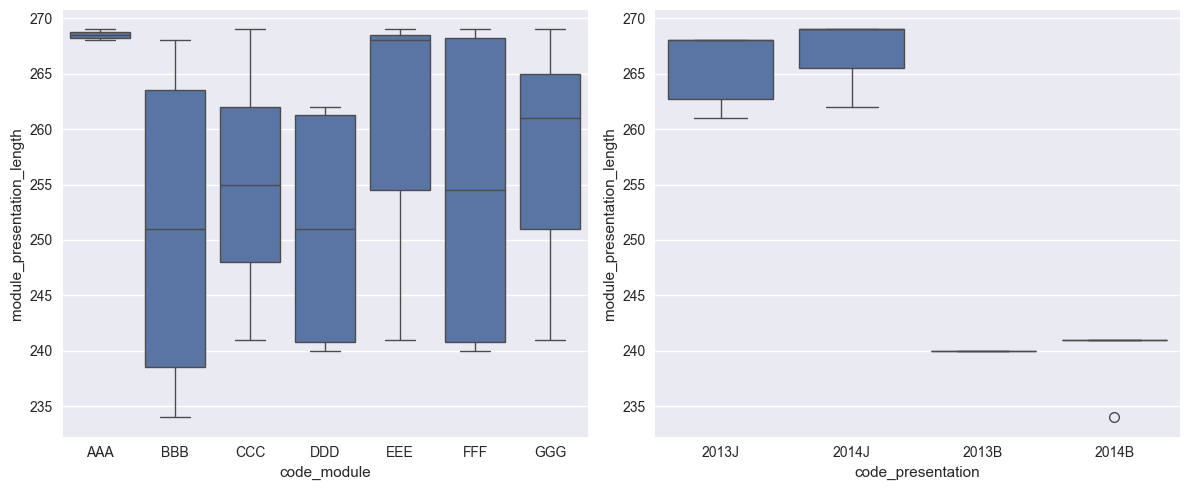

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

sns.boxplot(data=df_courses, x='code_module', y='module_presentation_length', ax = axes[0])
sns.boxplot(data=df_courses, x='code_presentation', y='module_presentation_length', ax = axes[1])

plt.tight_layout()



There is no clear visual difference between code_modules (left). The 'J' code_presenations are clearly longer (right). We will split the code_presentation column in year and month and check again.

In [79]:
df_courses[['year', 'start_month']] = df_courses['code_presentation'].str.extract(r'(\d{4})([A-Za-z])')
df_courses.loc[df_courses['start_month'] == 'J', 'start_month'] = 'October'
df_courses.loc[df_courses['start_month'] == 'B', 'start_month'] = 'February'
df_courses.head()


,code_module,code_presentation,module_presentation_length,year,start_month
0,AAA,2013J,268,2013,October
1,AAA,2014J,269,2014,October
2,BBB,2013J,268,2013,October
3,BBB,2014J,262,2014,October
4,BBB,2013B,240,2013,February


**Conclusion:**

There are 7 unique modules and 4 unique presentations, for a total of 22 unique course presentations. The combination between code_module and code_presentation can be used as a unique identifier.

The courses are between 234 and 269 days long with an average of 255 days. code_presentation seems to be related to module_presentation_length.

We have split the code_presentation into year and month.
 
There is are no duplicate rows or missing data.

## assessments

code_module – identification code of the module, to which the assessment belongs.

code_presentation - identification code of the presentation, to which the assessment belongs.

id_assessment – identification number of the assessment.

assessment_type – type of assessment. Three types of assessments exist: Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA) and Final Exam (Exam).

date – information about the final submission date of the assessment calculated as the number of days since the start of the module-presentation. The starting date of the presentation has number 0 (zero).

weight - weight of the assessment in %. Typically, Exams are treated separately and have the weight 100%; the sum of all other assessments is 100%.

In [80]:
df_assessments = first_inspection('assessments')

Table 'assessments':

Head:
  code_module code_presentation  id_assessment assessment_type   date  weight
0         AAA             2013J           1752             TMA   19.0    10.0
1         AAA             2013J           1753             TMA   54.0    20.0
2         AAA             2013J           1754             TMA  117.0    20.0
3         AAA             2013J           1755             TMA  166.0    20.0
4         AAA             2013J           1756             TMA  215.0    30.0

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: f

In [81]:
# Check uniqueness identifiers
df_assessments['id_assessment'].duplicated().sum()


np.int64(0)

There is over 5% missing data in 'date'. Let's take a look at that data.

In [82]:
df_assessments[df_assessments['date'].isna()]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


All are exams. Are there any exams with a date?

In [83]:
df_assessments[df_assessments['assessment_type']=='Exam']

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


Are the missing dates related to the module_presentation_length?

In [84]:
df_assessments_with_course_length = df_assessments.merge(df_courses[['code_module', 'code_presentation', 'module_presentation_length']], on=['code_module', 'code_presentation'])
# ensure that merge found module_presentation_length for each row
df_assessments_with_course_length['module_presentation_length'].isna().sum()

np.int64(0)

In [85]:
df_assessments_with_course_length['days_from_end'] = df_assessments_with_course_length['module_presentation_length'] - df_assessments_with_course_length['date']
df_assessments_with_course_length[df_assessments_with_course_length['assessment_type']=='Exam']

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length,days_from_end
5,AAA,2013J,1757,Exam,NaN,100.0,268,NaN
11,AAA,2014J,1763,Exam,NaN,100.0,269,NaN
23,BBB,2013B,14990,Exam,NaN,100.0,240,NaN
35,BBB,2013J,15002,Exam,NaN,100.0,268,NaN
47,BBB,2014B,15014,Exam,NaN,100.0,234,NaN
53,BBB,2014J,15025,Exam,NaN,100.0,262,NaN
62,CCC,2014B,24290,Exam,NaN,100.0,241,NaN
63,CCC,2014B,40087,Exam,NaN,100.0,241,NaN
72,CCC,2014J,24299,Exam,NaN,100.0,269,NaN
73,CCC,2014J,40088,Exam,NaN,100.0,269,NaN


Not many exams fall on the last day. We'll assume a missing date means that the exam is one the last day of the module presentation.

In [86]:
df_assessments.loc[
    (df_assessments['date'].isna()) & 
    (df_assessments['assessment_type'] == 'Exam'), 
    'date'
] = df_assessments_with_course_length['module_presentation_length']

In [87]:
df_assessments['date'].isna().sum()

np.int64(0)

We no longer have missing data.

We'll verify that all dates fall within the module_presentation_length as well. 

In [88]:
(df_assessments_with_course_length['date'] > df_assessments_with_course_length['module_presentation_length']).sum()

np.int64(0)

We'll verify that the weight of all assessments per course add up to the same number as well. We expect weights of 200 (100 for exam, 100 for other assessments).

In [89]:
df_assessments.groupby(['code_module', 'code_presentation'])['weight'].sum()

code_module  code_presentation
AAA          2013J                200.0
             2014J                200.0
BBB          2013B                200.0
             2013J                200.0
             2014B                200.0
             2014J                200.0
CCC          2014B                300.0
             2014J                300.0
DDD          2013B                200.0
             2013J                200.0
             2014B                200.0
             2014J                200.0
EEE          2013J                200.0
             2014B                200.0
             2014J                200.0
FFF          2013B                200.0
             2013J                200.0
             2014B                200.0
             2014J                200.0
GGG          2013J                100.0
             2014B                100.0
             2014J                100.0
Name: weight, dtype: float64

We find unexpected values, but the weights are the same for each code_module. We'll take a deeper look at code_modules CCC and GGG.

In [90]:
df_assessments[df_assessments['code_module'].isin(['CCC','GGG'])].groupby(['code_module', 'code_presentation', 'assessment_type'])['weight'].sum()

code_module  code_presentation  assessment_type
CCC          2014B              CMA                 25.0
                                Exam               200.0
                                TMA                 75.0
             2014J              CMA                 25.0
                                Exam               200.0
                                TMA                 75.0
GGG          2013J              CMA                  0.0
                                Exam               100.0
                                TMA                  0.0
             2014B              CMA                  0.0
                                Exam               100.0
                                TMA                  0.0
             2014J              CMA                  0.0
                                Exam               100.0
                                TMA                  0.0
Name: weight, dtype: float64

Module GGG only has exams. CCC has a weight of 200, which is unexpected if there is only one exam. We'll verify that. 

In [91]:
df_assessments[df_assessments['code_module'].isin(['CCC','GGG'])].groupby(['code_module', 'code_presentation', 'assessment_type'])['weight'].count()

code_module  code_presentation  assessment_type
CCC          2014B              CMA                4
                                Exam               2
                                TMA                4
             2014J              CMA                4
                                Exam               2
                                TMA                4
GGG          2013J              CMA                6
                                Exam               1
                                TMA                3
             2014B              CMA                6
                                Exam               1
                                TMA                3
             2014J              CMA                6
                                Exam               1
                                TMA                3
Name: weight, dtype: int64

There are two exams, each with a weight of 100. We have no reason to believe this isn't correct for now. We can try to replicate the end result calculation later on.

**Conclusion:**

There are 206 unique assessments with a weight between 0 and 100. Per unique course presentation, the total weight can be 100 (only exam) to 300 (two exams and other assessments). We have replaced the only missing data (date for some Exam assessments) with the last day of the repective course.

## vle

id_site – an identification number of the material.

code_module – an identification code for module.

code_presentation - the identification code of presentation.

activity_type – the role associated with the module material.

week_from – the week from which the material is planned to be used.

week_to – week until which the material is planned to be used.

In [92]:
df_vle = first_inspection('vle')

Table 'vle':

Head:
   id_site code_module code_presentation activity_type  week_from  week_to
0   546943         AAA             2013J      resource        NaN      NaN
1   546712         AAA             2013J     oucontent        NaN      NaN
2   546998         AAA             2013J      resource        NaN      NaN
3   546888         AAA             2013J           url        NaN      NaN
4   547035         AAA             2013J      resource        NaN      NaN

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), obj

In [93]:
# Check uniqueness identifiers
df_vle['id_site'].duplicated().sum()


np.int64(0)

There are 6364 unique rows, and the identifier is unique for each entry.

Over 80% of data doesn't have a week_from or week_to.

Are there rows where only one of week_from/week_to are missing?


In [94]:
len(df_vle[df_vle['week_from'].isna() ^ df_vle['week_to'].isna()])

0

It appears that either both, or neither are missing. Let's verify that week_from is never bigger than week_to.

In [95]:
len(df_vle[df_vle['week_from'] > df_vle['week_to']])

0

That checks out. We'll check if the missing data is related to the code_module, code_presentation, or activity_type.

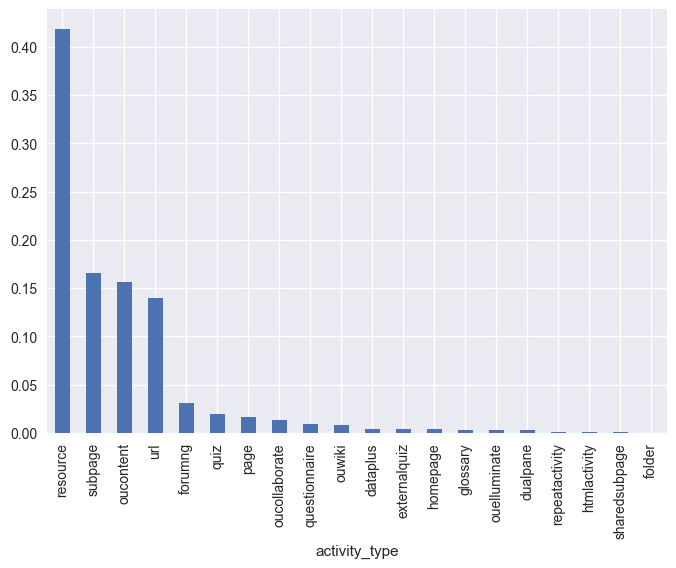

In [96]:
# Distribution of activity_type
df_vle['activity_type'].value_counts(normalize=True).plot.bar();

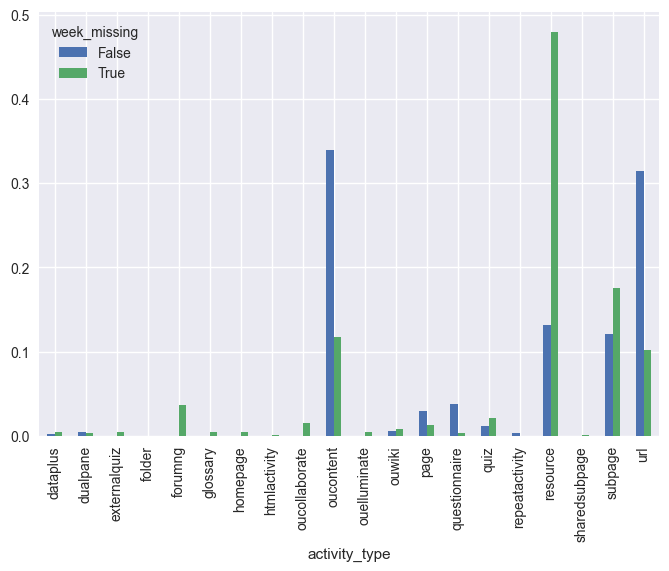

In [97]:
# distribution of resource_type for week_missing and !week_missing
df_vle['week_missing'] = df_vle['week_from'].isna()

(df_vle.groupby(['week_missing', 'activity_type'])
 .size()
 .unstack(level=0)
 .fillna(0)
 .apply(lambda x: x / x.sum(), axis=0)).plot.bar();


Missing data seems related to the resource_type. Goes the same for code_module and code_presentation?

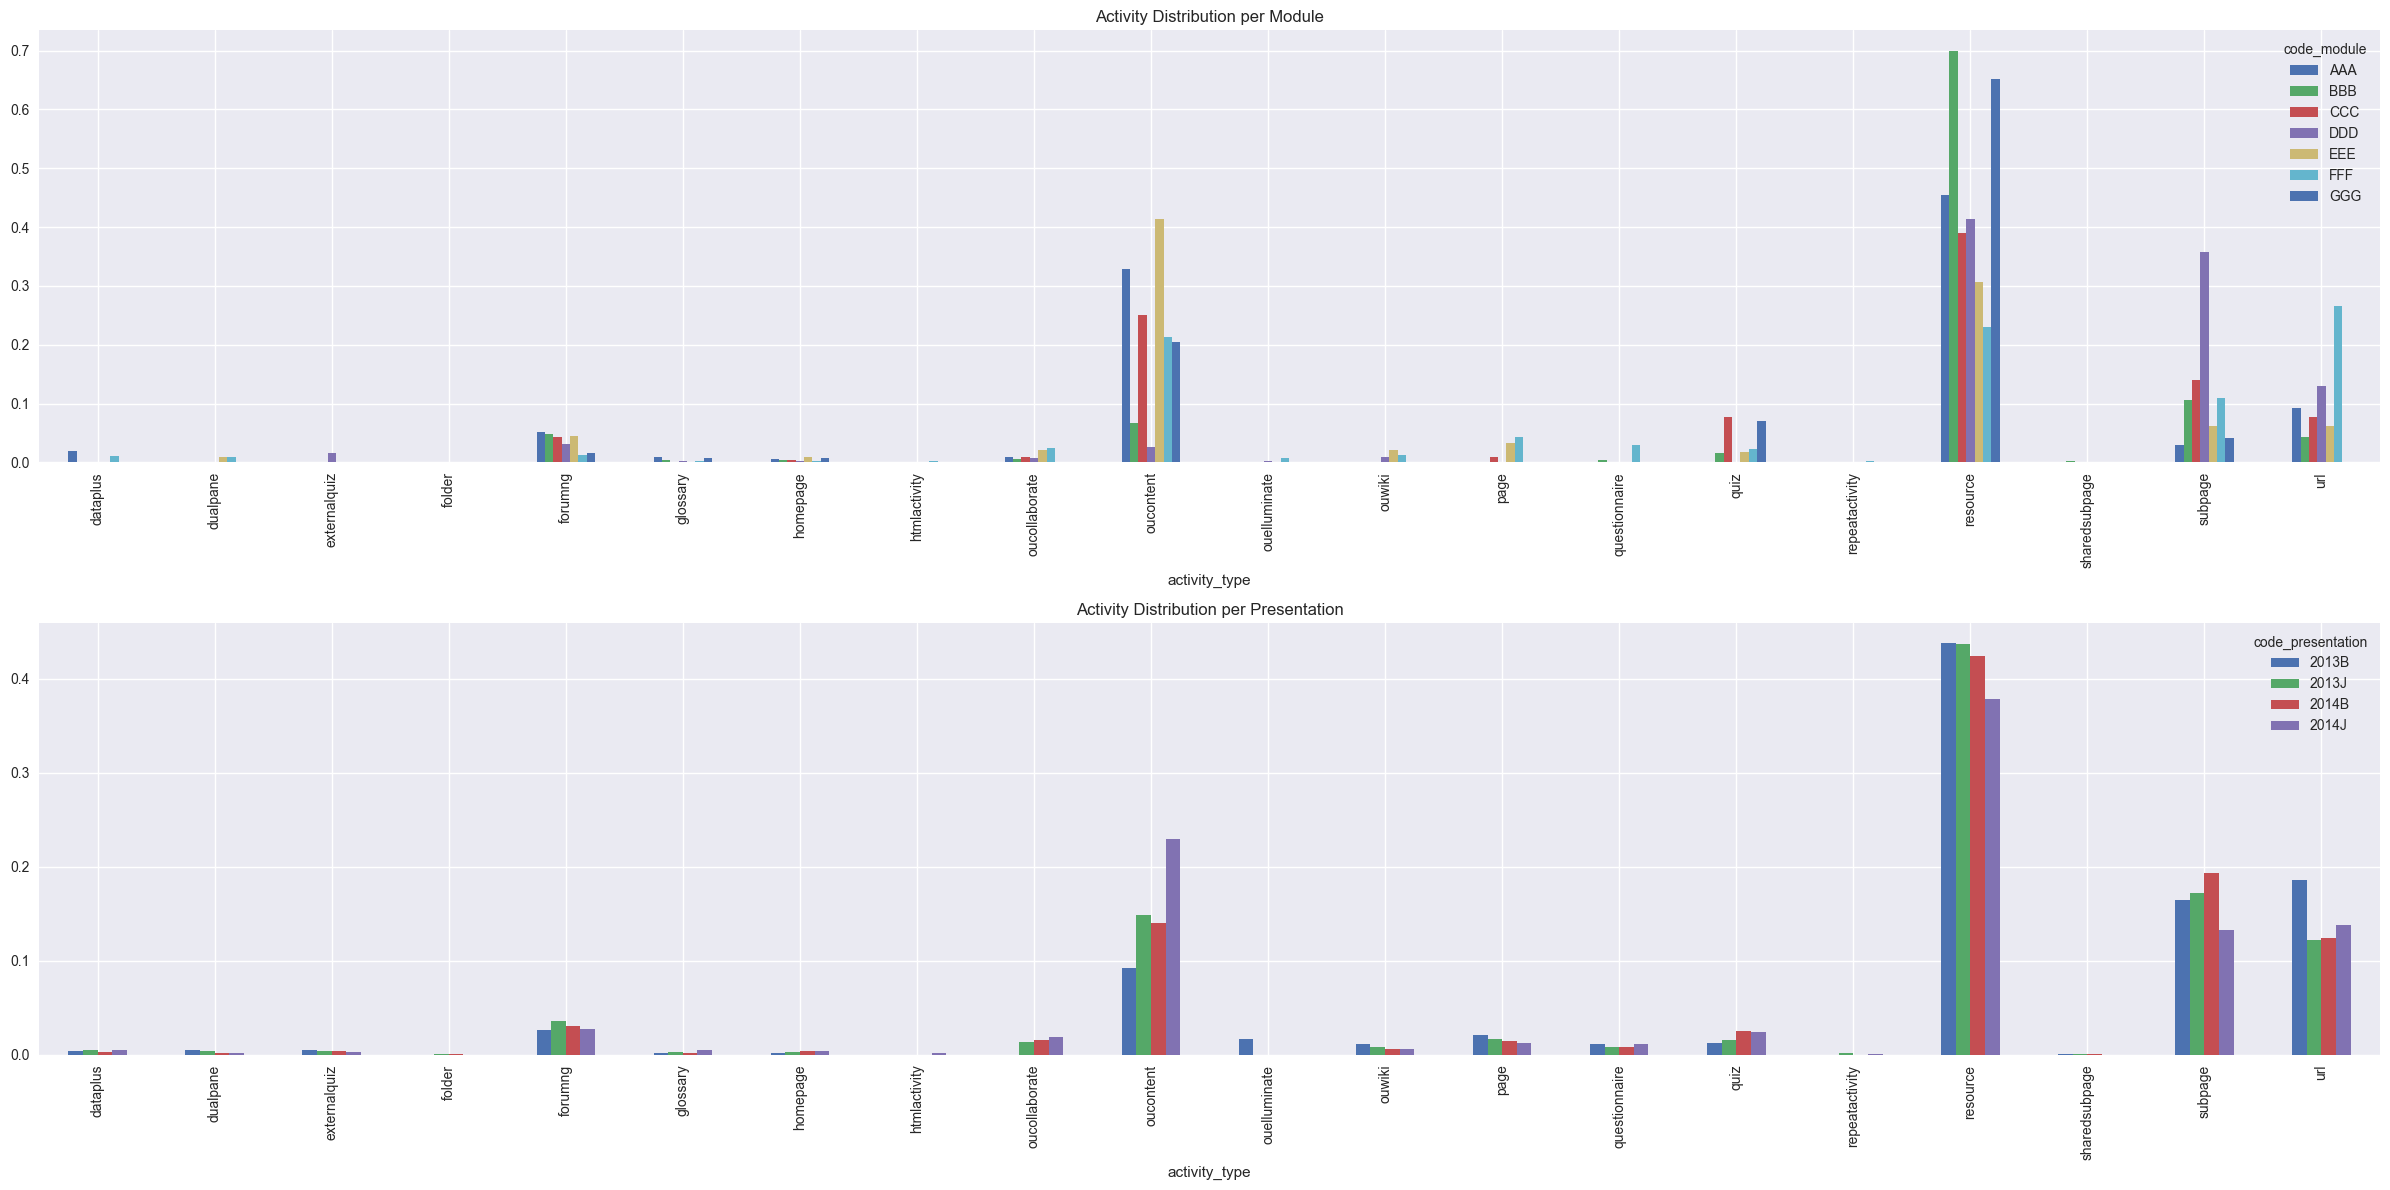

In [98]:
fig, axes = plt.subplots(2, 1, figsize=(24, 12))
axes = axes.flatten()

axes[0].set_title("Activity Distribution per Module")
(df_vle.groupby(['code_module', 'activity_type'])
           .size()
           .unstack(level=0)
           .fillna(0)
           .apply(lambda x: x / x.sum(), axis=0)).plot.bar(ax = axes[0])

axes[1].set_title("Activity Distribution per Presentation")
(df_vle.groupby(['code_presentation', 'activity_type'])
           .size()
           .unstack(level=0)
           .fillna(0)
           .apply(lambda x: x / x.sum(), axis=0)).plot.bar(ax = axes[1])

plt.tight_layout()



There are big differences for code_module, less so for code_presentation.

**Conclusion:**

There are 6364 unique vle's. week_from and week_to are missing in many cases, and this seems to differ per code_module and resource_type.

## studentInfo

code_module – an identification code for a module on which the student is registered.

code_presentation - the identification code of the presentation during which the student is registered on the module.

id_student – a unique identification number for the student.

gender – the student’s gender.

region – identifies the geographic region, where the student lived while taking the module-presentation.

highest_education – highest student education level on entry to the module presentation.

imd_band – specifies the Index of Multiple Depravation band of the place where the student lived during the module-presentation.

age_band – band of the student’s age.

num_of_prev_attempts – the number times the student has attempted this module.

studied_credits – the total number of credits for the modules the student is currently studying.

disability – indicates whether the student has declared a disability.

final_result – student’s final result in the module-presentation.

In [99]:
df_studentinfo = first_inspection('studentInfo')

Table 'studentInfo':

Head:
  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability final_result  
0              240          N         Pass  
1               

In [100]:
# Check uniqueness identifiers
df_studentinfo['id_student'].duplicated().sum()


np.int64(3808)

There are 32593 unique rows. There is missing data dor imd_band, but less than 4%. We'll decide what to do with that later. There are two particularities:
* 3808 duplicates for id_student
* a max of studied_credits of 655

We'll first look at the rows with duplicate id's

In [101]:
duplicates_studentinfo = df_studentinfo[df_studentinfo.groupby('id_student')['id_student'].transform('count') > 1].sort_values('id_student')
duplicates_studentinfo.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
14395,DDD,2013J,8462,M,London Region,HE Qualification,30-40%,55<=,0,90,N,Withdrawn
17560,DDD,2014J,8462,M,London Region,HE Qualification,30-40%,55<=,1,60,N,Withdrawn
16332,DDD,2014B,24213,F,East Anglian Region,A Level or Equivalent,40-50%,0-35,1,60,N,Pass
13091,DDD,2013B,24213,F,East Anglian Region,A Level or Equivalent,40-50%,0-35,0,90,N,Withdrawn
4752,BBB,2014B,25629,F,Scotland,Lower Than A Level,20-30%,0-35,1,120,N,Withdrawn


There are multiple rows per student. Are columns like region always the same per student?

In [102]:
# calculate percentage consistency per variable (per id_student-)
consistency = duplicates_studentinfo.groupby('id_student').agg(
    lambda x: x.nunique() == 1
).mean() * 100

summary = pd.DataFrame({
    'same_percentage': consistency.round(2)
}).sort_values('same_percentage', ascending=False)
summary

,same_percentage
gender,100.00
highest_education,100.00
region,100.00
disability,100.00
age_band,97.96
imd_band,96.18
studied_credits,67.52
num_of_prev_attempts,60.34
final_result,45.48
code_module,29.93


For a unique student:
* non-changing columns: gender, highest_education, region, disability
* barely changing columns (<5%): age_band, imd_band

Other columns change per registration. 

Let's look at studied_credits, since a value of 655 seems high.

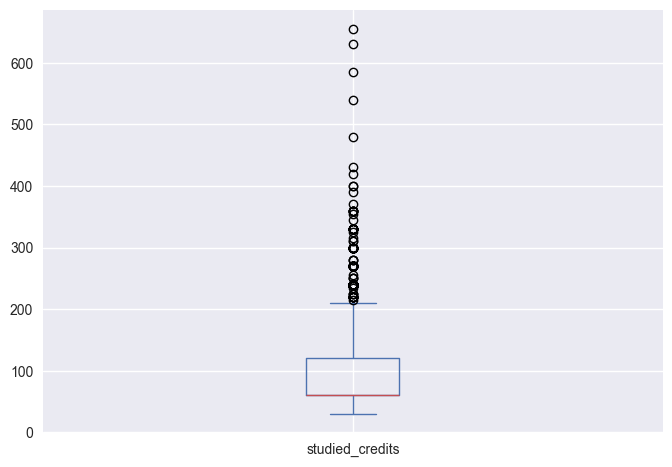

In [103]:
df_studentinfo['studied_credits'].plot.box();

There seem to be quite a lot of high numbers. Let's look at some specific students.

In [104]:
# get id's of students with ovr 400 credits
student_ids = df_studentinfo[df_studentinfo['studied_credits']>300]['id_student'].unique()
# find all entries for these students
df_studentinfo[df_studentinfo['id_student'].isin(student_ids)].sort_values(by='id_student')

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
8690,CCC,2014B,88758,M,North Region,Post Graduate Qualification,NaN,35-55,0,330,N,Withdrawn
10632,CCC,2014J,88758,M,North Region,Post Graduate Qualification,NaN,35-55,1,150,N,Withdrawn
22337,FFF,2013B,110085,M,Ireland,Lower Than A Level,NaN,0-35,1,310,N,Fail
27748,FFF,2014J,131597,M,Scotland,A Level or Equivalent,40-50%,0-35,0,430,N,Pass
426,AAA,2014J,141377,M,South West Region,A Level or Equivalent,90-100%,0-35,1,210,N,Pass
48,AAA,2013J,141377,M,South West Region,A Level or Equivalent,90-100%,0-35,0,345,N,Withdrawn
8734,CCC,2014B,153687,F,South Region,A Level or Equivalent,60-70%,35-55,0,400,N,Withdrawn
57,AAA,2013J,155550,M,London Region,A Level or Equivalent,0-10%,35-55,0,420,N,Pass
865,BBB,2013B,230348,F,East Anglian Region,A Level or Equivalent,0-10%,0-35,2,585,N,Withdrawn
16424,DDD,2014B,244438,M,North Western Region,A Level or Equivalent,10-20,0-35,1,540,N,Withdrawn


I'm not seeing a logical explanation when looking at the trajectory for each student. Since I don't know what values are realistic, I will leave this column as is.

Let's look at some categorical data (region, highest_education, imd_band, age_band, final_result)

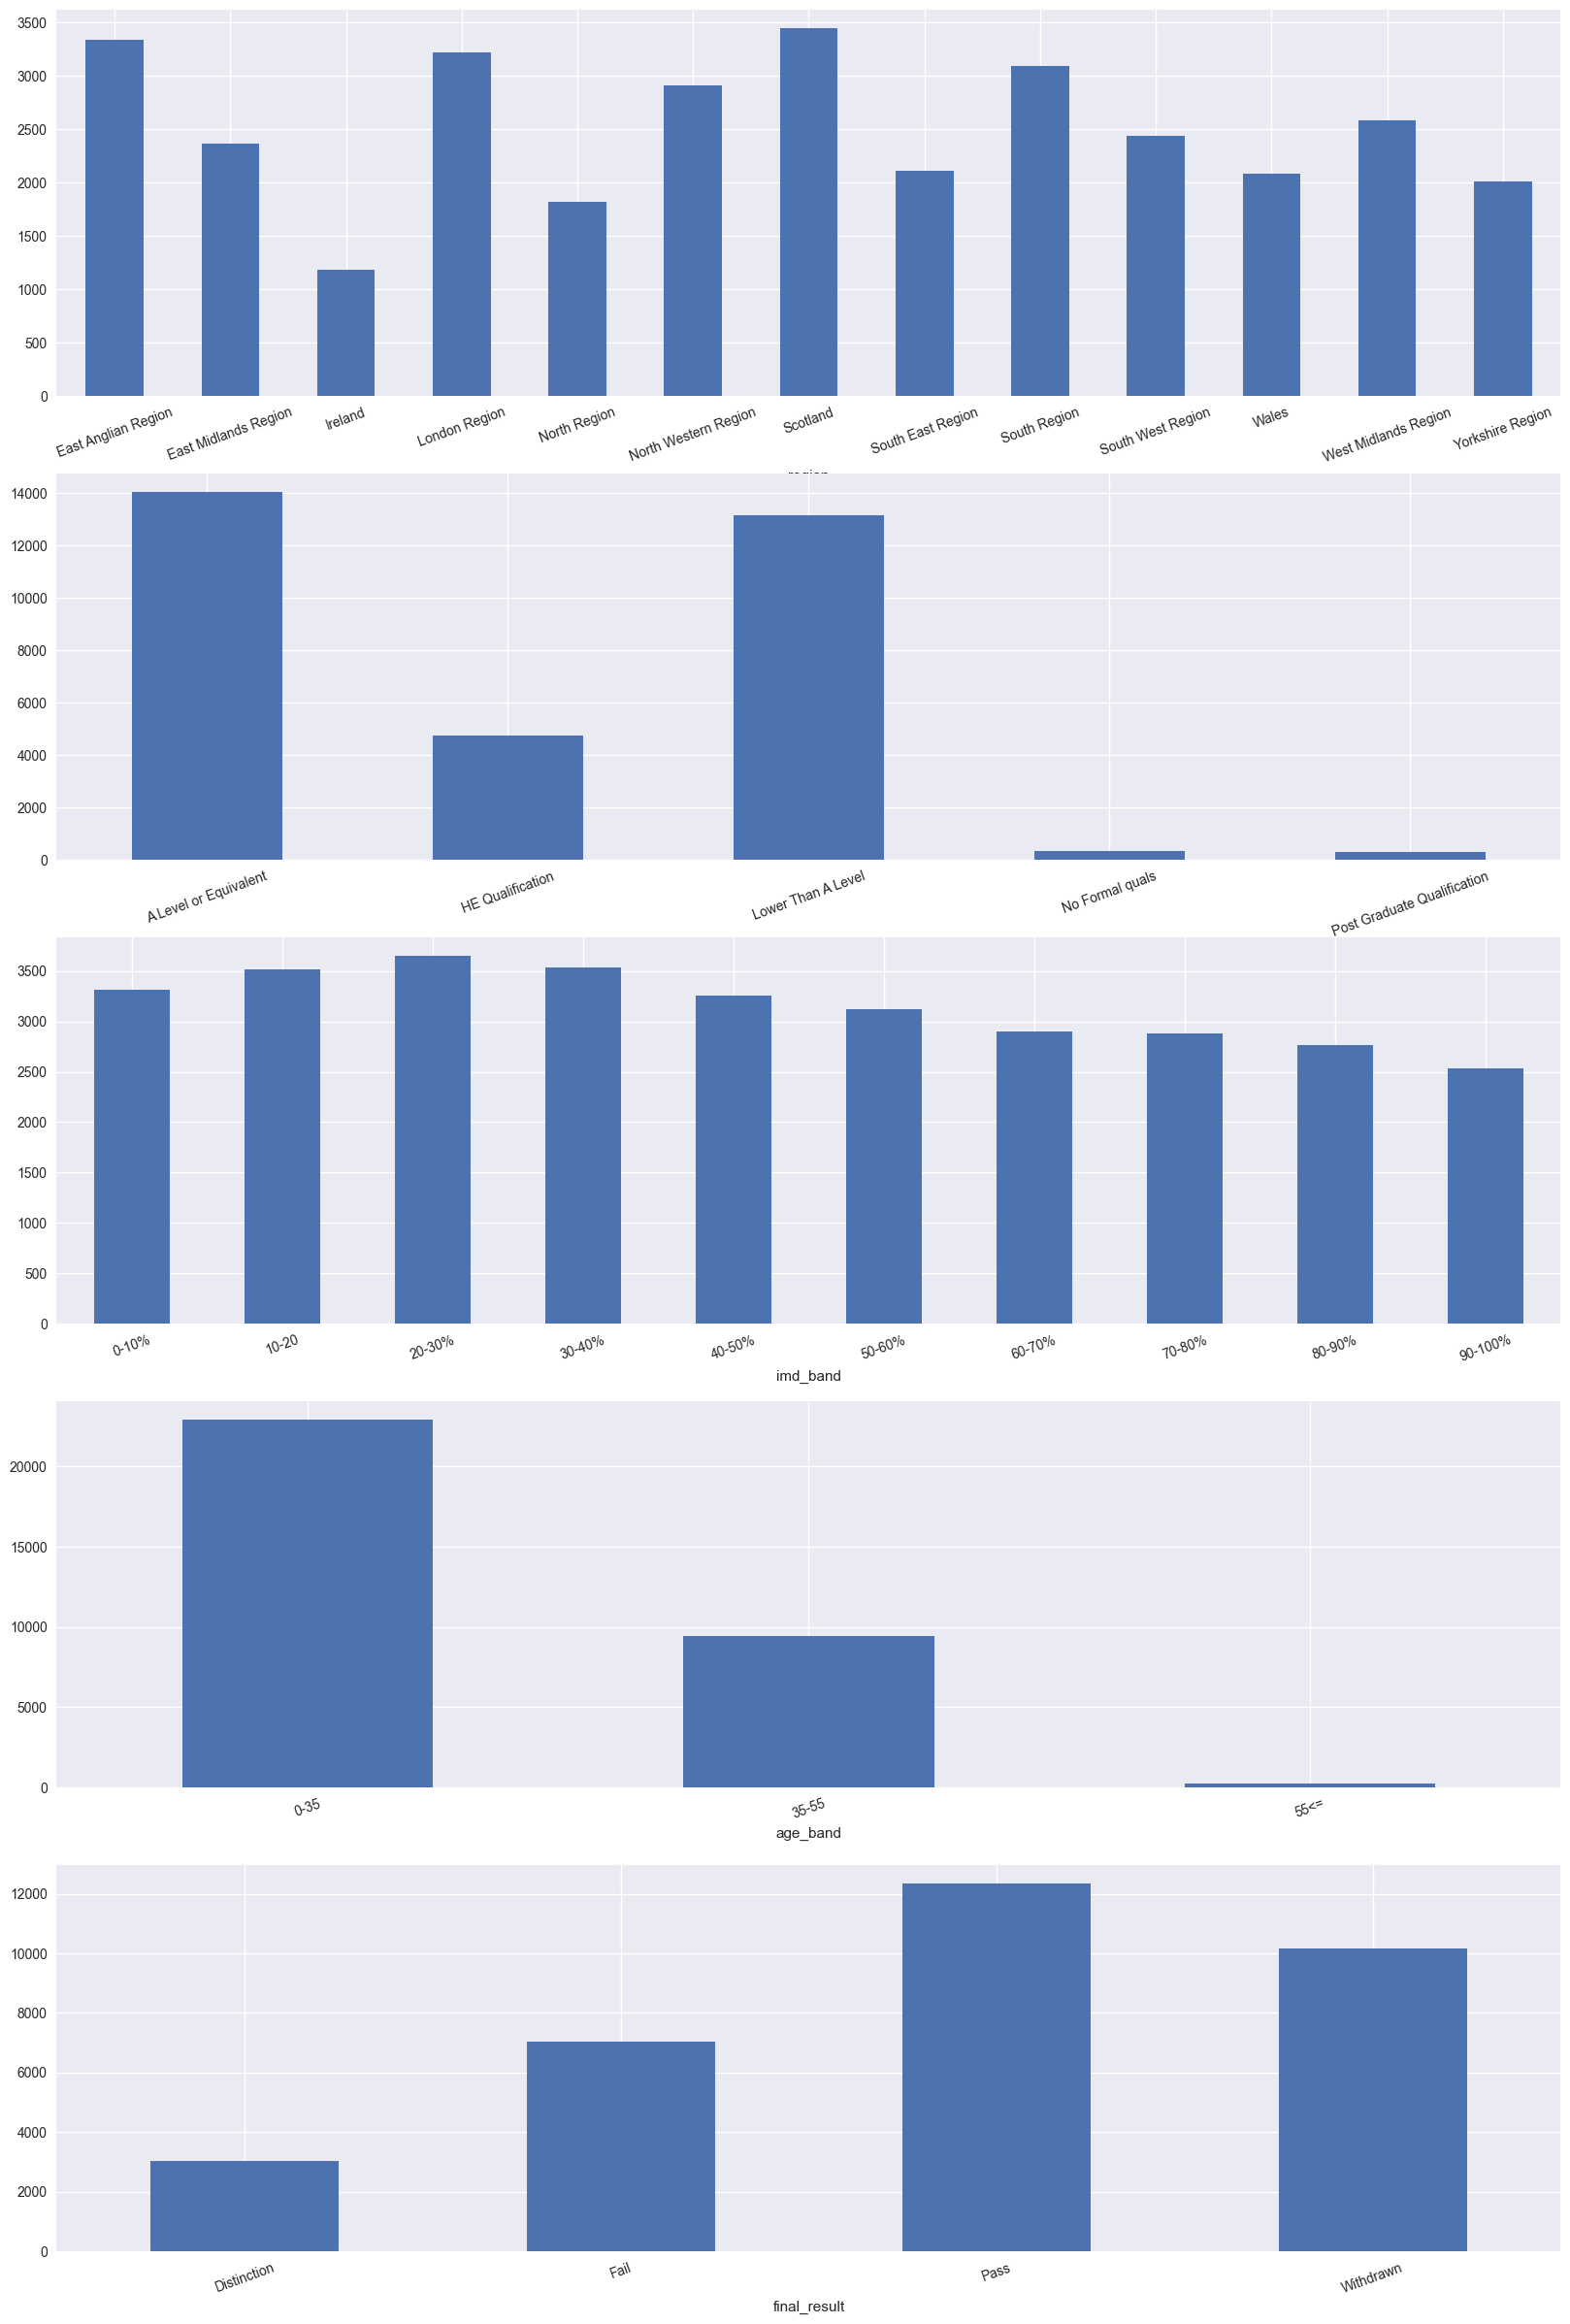

In [105]:
categoricals = ['region', 'highest_education', 'imd_band', 'age_band', 'final_result']




fig, axes = plt.subplots(5, 1, figsize=(20, 30))
axes = axes.flatten()

for i, categorical in enumerate(categoricals):
    df_studentinfo[categorical].sort_values().value_counts(sort=False).plot.bar(ax = axes[i], rot=20)


**Conclusion:**

There are 32593 unique rows. Each row represents a registration for a course, leading to multiple rows per student (denormalised table). Only imd_band has missing data (<4%).

## studentRegistration

code_module – an identification code for a module.

code_presentation - the identification code of the presentation.

id_student – a unique identification number for the student.

date_registration – the date of student’s registration on the module presentation, this is the number of days measured relative to the start of the module-presentation (e.g. the negative value -30 means that the student registered to module presentation 30 days before it started).

date_unregistration – date of student unregistration from the module presentation, this is the number of days measured relative to the start of the module-presentation. Students, who completed the course have this field empty. Students who unregistered have Withdrawal as the value of the final_result column in the studentInfo.csv file.

In [106]:
df_studentregistration = first_inspection('studentRegistration')

Table 'studentRegistration':

Head:
  code_module code_presentation  id_student  date_registration  \
0         AAA             2013J       11391             -159.0   
1         AAA             2013J       28400              -53.0   
2         AAA             2013J       30268              -92.0   
3         AAA             2013J       31604              -52.0   
4         AAA             2013J       32885             -176.0   

   date_unregistration  
0                  NaN  
1                  NaN  
2                 12.0  
3                  NaN  
4                  NaN  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4

In [107]:
# Check uniqueness identifiers
df_studentregistration[['id_student']].duplicated().sum()


np.int64(3808)

There are 32593 unique rows, with 3808 duplicates for id_student. This is the same number of duplicates as in StudentInfo. Let's check if both tables are the same size.

In [108]:
# same length as studentinfo?
len(dfs['studentRegistration'])==len(dfs['studentInfo'])

True

The table StudentInfo contains some data that is better suited for the table studentRegistration. We'll move these columns.

In [109]:
df_studentregistration = df_studentregistration.merge(df_studentinfo[['id_student', 'age_band', 'imd_band', 'studied_credits', 'num_of_prev_attempts', 'final_result', 'code_module', 'code_presentation']], on=['id_student', 'code_module', 'code_presentation'])
df_studentregistration.head()
	


,code_module,code_presentation,id_student,date_registration,date_unregistration,age_band,imd_band,studied_credits,num_of_prev_attempts,final_result
0,AAA,2013J,11391,-159.0,NaN,55<=,90-100%,240,0,Pass
1,AAA,2013J,28400,-53.0,NaN,35-55,20-30%,60,0,Pass
2,AAA,2013J,30268,-92.0,12.0,35-55,30-40%,60,0,Withdrawn
3,AAA,2013J,31604,-52.0,NaN,35-55,50-60%,60,0,Pass
4,AAA,2013J,32885,-176.0,NaN,0-35,50-60%,60,0,Pass


In [110]:
df_studentinfo = df_studentinfo.drop(columns=['code_module','code_presentation','imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'final_result']).drop_duplicates()
df_studentinfo.head()

,id_student,gender,region,highest_education,disability
0,11391,M,East Anglian Region,HE Qualification,N
1,28400,F,Scotland,HE Qualification,N
2,30268,F,North Western Region,A Level or Equivalent,Y
3,31604,F,South East Region,A Level or Equivalent,N
4,32885,F,West Midlands Region,Lower Than A Level,N


We'll take a look at the missing values for date_registration.

In [111]:
df_studentregistration[df_studentregistration['date_registration'].isna()]

,code_module,code_presentation,id_student,date_registration,date_unregistration,age_band,imd_band,studied_credits,num_of_prev_attempts,final_result
2344,BBB,2013B,630346,NaN,NaN,0-35,60-70%,60,0,Fail
2538,BBB,2013J,57369,NaN,-1.0,35-55,40-50%,60,0,Withdrawn
2759,BBB,2013J,342678,NaN,-33.0,0-35,50-60%,90,1,Withdrawn
5356,BBB,2014B,582496,NaN,-126.0,0-35,0-10%,120,0,Withdrawn
5490,BBB,2014B,607646,NaN,-38.0,0-35,10-20,60,0,Withdrawn
5573,BBB,2014B,614270,NaN,-142.0,0-35,50-60%,120,0,Withdrawn
6295,BBB,2014B,2409808,NaN,-109.0,35-55,60-70%,120,4,Withdrawn
6305,BBB,2014B,2439442,NaN,-149.0,0-35,20-30%,150,0,Withdrawn
8307,BBB,2014J,694001,NaN,-36.0,0-35,20-30%,180,0,Withdrawn
8975,CCC,2014B,394791,NaN,-61.0,0-35,40-50%,90,0,Withdrawn


In [112]:
df_studentregistration[(df_studentregistration['date_registration'].isna()) & (df_studentregistration['final_result'] == 'Withdrawn')]


,code_module,code_presentation,id_student,date_registration,date_unregistration,age_band,imd_band,studied_credits,num_of_prev_attempts,final_result
2538,BBB,2013J,57369,NaN,-1.0,35-55,40-50%,60,0,Withdrawn
2759,BBB,2013J,342678,NaN,-33.0,0-35,50-60%,90,1,Withdrawn
5356,BBB,2014B,582496,NaN,-126.0,0-35,0-10%,120,0,Withdrawn
5490,BBB,2014B,607646,NaN,-38.0,0-35,10-20,60,0,Withdrawn
5573,BBB,2014B,614270,NaN,-142.0,0-35,50-60%,120,0,Withdrawn
6295,BBB,2014B,2409808,NaN,-109.0,35-55,60-70%,120,4,Withdrawn
6305,BBB,2014B,2439442,NaN,-149.0,0-35,20-30%,150,0,Withdrawn
8307,BBB,2014J,694001,NaN,-36.0,0-35,20-30%,180,0,Withdrawn
8975,CCC,2014B,394791,NaN,-61.0,0-35,40-50%,90,0,Withdrawn
9523,CCC,2014B,575419,NaN,-24.0,0-35,50-60%,90,0,Withdrawn


It seems that early unregistrations result in a 'Withdrawn' final_result and NaN for date_registration. Let's verify the date_unregistration for these entries, and whether there are any exceptions.

In [113]:
# do all entries with missing date_registration and 'Withdrawn' have an early date_unregistration
df_studentregistration[(df_studentregistration['date_registration'].isna()) & (df_studentregistration['final_result'] == 'Withdrawn')]['date_unregistration'].describe()

count     39.000000
mean     -83.641026
std       86.068054
min     -365.000000
25%     -145.500000
50%      -75.000000
75%      -31.000000
max      146.000000
Name: date_unregistration, dtype: float64

In [114]:
# are there any missing date_unregistration for entries with missing date_registration and 'Withdrawn' have an early date_unregistration
df_studentregistration[(df_studentregistration['date_registration'].isna()) & (df_studentregistration['final_result'] == 'Withdrawn')]['date_unregistration'].isna().sum()

np.int64(0)

There are late unregistrations with a missing date_registration. Are there any 'Withdrawn' final_result entries without an unregistration date?

In [115]:
df_studentregistration[(df_studentregistration['final_result'] == 'Withdrawn') & (df_studentregistration['date_unregistration'].isna())]

,code_module,code_presentation,id_student,date_registration,date_unregistration,age_band,imd_band,studied_credits,num_of_prev_attempts,final_result
6315,BBB,2014B,2512349,-17.0,NaN,35-55,40-50%,60,0,Withdrawn
6484,BBB,2014J,271047,-25.0,NaN,0-35,90-100%,60,0,Withdrawn
6601,BBB,2014J,417978,-24.0,NaN,35-55,80-90%,60,0,Withdrawn
7247,BBB,2014J,636660,-113.0,NaN,0-35,0-10%,60,0,Withdrawn
7410,BBB,2014J,647876,-162.0,NaN,0-35,80-90%,120,0,Withdrawn
...,...,...,...,...,...,...,...,...,...,...
29978,FFF,2014J,2398260,-38.0,NaN,35-55,10-20,180,0,Withdrawn
30032,FFF,2014J,2622634,-29.0,NaN,35-55,10-20,60,1,Withdrawn
30562,GGG,2013J,590248,-16.0,NaN,0-35,30-40%,30,0,Withdrawn
32149,GGG,2014J,646891,2.0,NaN,35-55,10-20,60,0,Withdrawn


There are many entries with 'Withdrawn' with a missing date_unregistration.

Are there any entries with both dates missing?

In [116]:
df_studentregistration[(df_studentregistration['date_registration'].isna()) & (df_studentregistration['date_unregistration'].isna())]


,code_module,code_presentation,id_student,date_registration,date_unregistration,age_band,imd_band,studied_credits,num_of_prev_attempts,final_result
2344,BBB,2013B,630346,NaN,NaN,0-35,60-70%,60,0,Fail
12893,CCC,2014J,1777834,NaN,NaN,35-55,80-90%,60,0,Pass
14392,DDD,2013B,2707979,NaN,NaN,0-35,60-70%,120,0,Fail
14393,DDD,2013B,2710343,NaN,NaN,0-35,0-10%,60,0,Fail
17559,DDD,2014B,2710343,NaN,NaN,0-35,0-10%,60,1,Fail
23796,FFF,2013B,2102658,NaN,NaN,35-55,50-60%,60,0,Fail


There are a few entries without any date_registration or date_unregistration. Most have 'Fail' as an final_result, one has 'Pass'.

Let's look at the missing date_unregistration (more than 69% missing).

In [117]:
df_studentregistration[df_studentregistration['date_unregistration'].isna()]

,code_module,code_presentation,id_student,date_registration,date_unregistration,age_band,imd_band,studied_credits,num_of_prev_attempts,final_result
0,AAA,2013J,11391,-159.0,NaN,55<=,90-100%,240,0,Pass
1,AAA,2013J,28400,-53.0,NaN,35-55,20-30%,60,0,Pass
3,AAA,2013J,31604,-52.0,NaN,35-55,50-60%,60,0,Pass
4,AAA,2013J,32885,-176.0,NaN,0-35,50-60%,60,0,Pass
5,AAA,2013J,38053,-110.0,NaN,35-55,80-90%,60,0,Pass
...,...,...,...,...,...,...,...,...,...,...
32587,GGG,2014J,2620947,-23.0,NaN,0-35,80-90%,30,0,Distinction
32588,GGG,2014J,2640965,-4.0,NaN,0-35,10-20,30,0,Fail
32589,GGG,2014J,2645731,-23.0,NaN,35-55,40-50%,30,0,Distinction
32590,GGG,2014J,2648187,-129.0,NaN,0-35,20-30%,30,0,Pass


In [118]:
# Let's look at the final_result
df_studentregistration[df_studentregistration['date_unregistration'].isna()]['final_result'].value_counts()

final_result
Pass           12361
Fail            7043
Distinction     3024
Withdrawn         93
Name: count, dtype: int64

In [119]:
# Let's look at the final_result for the entries with date_unregistration
df_studentregistration[~(df_studentregistration['date_unregistration']).isna()]['final_result'].value_counts()


final_result
Withdrawn    10063
Fail             9
Name: count, dtype: int64

In [120]:
# Why ddi some students get 'Fail' when unregistering
df_studentregistration[~(df_studentregistration['date_unregistration'].isna()) & (df_studentregistration['final_result']=='Fail')]

,code_module,code_presentation,id_student,date_registration,date_unregistration,age_band,imd_band,studied_credits,num_of_prev_attempts,final_result
2777,BBB,2013J,362907,-37.0,0.0,35-55,20-30%,60,2,Fail
2786,BBB,2013J,365288,-75.0,0.0,0-35,70-80%,60,0,Fail
3340,BBB,2013J,554243,-35.0,166.0,0-35,60-70%,60,0,Fail
14625,DDD,2013J,315082,-73.0,0.0,0-35,50-60%,60,0,Fail
14768,DDD,2013J,403052,-22.0,0.0,0-35,20-30%,150,0,Fail
15577,DDD,2013J,582954,-81.0,-7.0,0-35,10-20,120,0,Fail
24057,FFF,2013J,234004,-33.0,0.0,0-35,50-60%,60,0,Fail
24537,FFF,2013J,523777,-60.0,0.0,35-55,0-10%,60,1,Fail
25685,FFF,2013J,601640,-58.0,-4.0,0-35,20-30%,90,0,Fail


There seem to be a few students who unregistered, but got a 'Fail'. Can it be due to late unregistration?

In [121]:
df_studentregistration[~(df_studentregistration['date_unregistration'].isna()) & (df_studentregistration['final_result']=='Withdrawn')]['date_unregistration'].describe()

count    10063.000000
mean        49.786744
std         82.476985
min       -365.000000
25%         -2.000000
50%         27.000000
75%        109.000000
max        444.000000
Name: date_unregistration, dtype: float64

The final_result doesn't seem related to the date_unregistration.

**Conclusion:**

There are 32593 unique rows. Each row represents a registration for a course. We have moved some columns from StudenInfo to StudentRegistration and delete duplicate rows in studentInfo (based on non-changing columns per student). 

There are a few entries with missing date_unregistration (<0.2%), and many for date_unregistration (> 69%). There are a few inaccuracies in the data:
* unepected final_result based on value date (un)registration
* missing date_registration

## studentAssessment

id_assessment – the identification number of the assessment.

id_student – a unique identification number for the student.

date_submitted – the date of student submission, measured as the number of days since the start of the module presentation.

is_banked – a status flag indicating that the assessment result has been transferred from a previous presentation.

score – the student’s score in this assessment. The range is from 0 to 100. The score lower than 40 is interpreted as Fail. The marks are in the range from 0 to 100.

In [122]:
df_studentassessment = first_inspection('studentAssessment')

Table 'studentAssessment':

Head:
   id_assessment  id_student  date_submitted  is_banked  score
0           1752       11391              18          0   78.0
1           1752       28400              22          0   70.0
2           1752       31604              17          0   72.0
3           1752       32885              26          0   69.0
4           1752       38053              19          0   79.0

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB
None

Percentage missing data:
id_assessment     0.000000
id_student        0.000000
date_submitted

In [123]:
# Check uniqueness identifiers
df_assessments[['id_assessment', 'id_assessment']].duplicated().sum()

np.int64(0)

There are a few missing scores. Let's take a look.

In [124]:
df_studentassessment[df_studentassessment['score'].isna()]

,id_assessment,id_student,date_submitted,is_banked,score
215,1752,721259,22,0,NaN
937,1754,260355,127,0,NaN
2364,1760,2606802,180,0,NaN
3358,14984,186780,77,0,NaN
3914,14984,531205,26,0,NaN
...,...,...,...,...,...
148929,34903,582670,241,0,NaN
159251,37415,610738,87,0,NaN
166390,37427,631786,221,0,NaN
169725,37435,648110,62,0,NaN


We'll look at the details later.

What are the submission dates for scores with is_banked?

In [125]:
df_studentassessment[df_studentassessment['is_banked']==1]['date_submitted']

1641     -1
1685     -1
1690     -1
1693     -1
1708     -1
         ..
172516   -1
172526   -1
172717   -1
172727   -1
173239   -1
Name: date_submitted, Length: 1909, dtype: int64

We'll replace these values with NaN as the -1 date_submission isn't usefull for is_banked scores.

In [126]:
df_studentassessment.loc[df_studentassessment['is_banked'] == 1, 'date_submitted'] = np.nan

**Conclusion:**

There are 173912 unique student assessments. The combination between id_Student and id_assessment form a unique identifier. Around of the scores 1% is banked, and a few scores are missing.

## studentVle

code_module – an identification code for a module.

code_presentation - the identification code of the module presentation.

id_student – a unique identification number for the student.

id_site - an identification number for the VLE material.

date – the date of student’s interaction with the material measured as the number of days since the start of the module-presentation.

sum_click – the number of times a student interacts with the material in that day

In [127]:
df_studentvle = first_inspection('studentVle')

Table 'studentVle':

Head:
  code_module code_presentation  id_student  id_site  date  sum_click
0         AAA             2013J       28400   546652   -10          4
1         AAA             2013J       28400   546652   -10          1
2         AAA             2013J       28400   546652   -10          1
3         AAA             2013J       28400   546614   -10         11
4         AAA             2013J       28400   546714   -10          1

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB
None

Percentage missing data:
code_module          0.0
code_presentation    0.0
id_student           0.0
id_site              0.0
d

There isn't a unique identifier, and there are many duplicate rows. The same student can interact with the same materials multiple times in the same day, so duplicate rows seems plausible.

Let's look at the dates.

<Axes: >

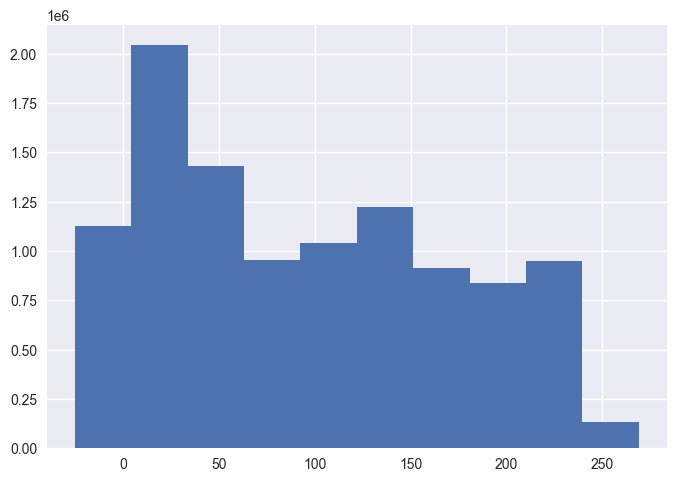

In [128]:
df_studentvle['date'].hist()

Nothing unexpected here. How about the sum_click variable?

<Axes: >

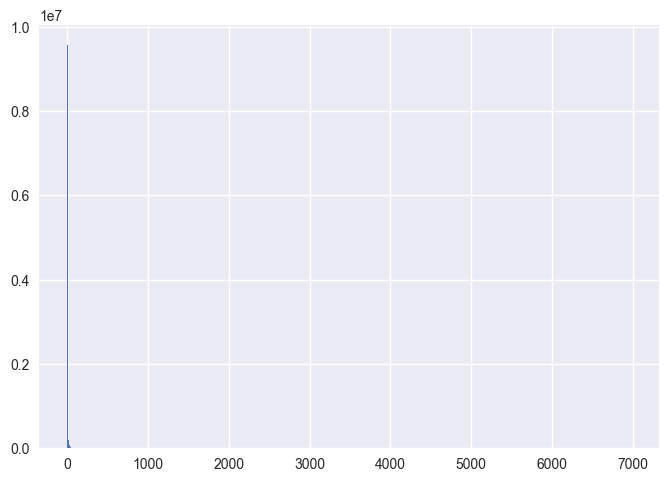

In [129]:
df_studentvle['sum_click'].hist(bins=1000)

The distribution has a very long tail (many people clikcing a few times, a few clicking many times)

# Further data exploration
We will take a deeper look at the relationship between tables.

## score, weights and final_result
We'll try to replicate the calculation of the final_result based on the scores of a student on assessments and the assessment weights.


In [130]:
df_studentregistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,age_band,imd_band,studied_credits,num_of_prev_attempts,final_result
0,AAA,2013J,11391,-159.0,NaN,55<=,90-100%,240,0,Pass
1,AAA,2013J,28400,-53.0,NaN,35-55,20-30%,60,0,Pass
2,AAA,2013J,30268,-92.0,12.0,35-55,30-40%,60,0,Withdrawn
3,AAA,2013J,31604,-52.0,NaN,35-55,50-60%,60,0,Pass
4,AAA,2013J,32885,-176.0,NaN,0-35,50-60%,60,0,Pass


In [131]:
# select specific module representation and student
code_module = 'AAA'
code_presentation = '2013J'
id_student = 11391

In [132]:
# select assessments of chosen module presentation
selected_assessments = df_assessments[(df_assessments['code_module']==code_module) & (df_assessments['code_presentation']==code_presentation)]
selected_assessments

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
5,AAA,2013J,1757,Exam,268.0,100.0


In [133]:
# add scores of student (NaN if no studentassessment)
selected_studentassessments = selected_assessments.merge(
    df_studentassessment[df_studentassessment['id_student']==id_student]
    [['id_assessment', 'score']],
    on=['id_assessment'],
    how='left'
)

selected_studentassessments

,code_module,code_presentation,id_assessment,assessment_type,date,weight,score
0,AAA,2013J,1752,TMA,19.0,10.0,78.0
1,AAA,2013J,1753,TMA,54.0,20.0,85.0
2,AAA,2013J,1754,TMA,117.0,20.0,80.0
3,AAA,2013J,1755,TMA,166.0,20.0,85.0
4,AAA,2013J,1756,TMA,215.0,30.0,82.0
5,AAA,2013J,1757,Exam,268.0,100.0,NaN


In [134]:
# calculate relative relative_Weight (percentage of total), and relative score (avsolute point of total)
total_weight = selected_studentassessments['weight'].sum()
selected_studentassessments['relative_weight'] = selected_studentassessments['weight']/total_weight
selected_studentassessments['relative_score'] = selected_studentassessments['score']*selected_studentassessments['relative_weight']
selected_studentassessments

,code_module,code_presentation,id_assessment,assessment_type,date,weight,score,relative_weight,relative_score
0,AAA,2013J,1752,TMA,19.0,10.0,78.0,0.05,3.9
1,AAA,2013J,1753,TMA,54.0,20.0,85.0,0.10,8.5
2,AAA,2013J,1754,TMA,117.0,20.0,80.0,0.10,8.0
3,AAA,2013J,1755,TMA,166.0,20.0,85.0,0.10,8.5
4,AAA,2013J,1756,TMA,215.0,30.0,82.0,0.15,12.3
5,AAA,2013J,1757,Exam,268.0,100.0,NaN,0.50,NaN


In [135]:
total_score = selected_studentassessments['relative_score'].sum()
final_result = df_studentregistration[
    (df_studentregistration['code_module']==code_module) & 
    (df_studentregistration['code_presentation']==code_presentation) & 
    (df_studentregistration['id_student']==id_student)]['final_result']

print(total_score, final_result)

41.199999999999996 0    Pass
Name: final_result, dtype: object


This student got a score of 41.20, and passed the course. We'll verify this for each registration using the function below.

In [136]:
def calculate_result(code_module, code_presentation, id_student):
    assessments = df_assessments[(df_assessments['code_module']==code_module) & (df_assessments['code_presentation']==code_presentation)]
    studentassessments = assessments.merge(
        df_studentassessment[df_studentassessment['id_student']==id_student]
        [['id_assessment', 'score']],
        on=['id_assessment'],
        how='left'
    )
    total_weight = studentassessments['weight'].sum()
    studentassessments['relative_weight'] = studentassessments['weight']/total_weight
    studentassessments['relative_score'] = studentassessments['score']*studentassessments['relative_weight']

    total_score = float(studentassessments['relative_score'].sum())
    final_result = df_studentregistration[
        (df_studentregistration['code_module']==code_module) & 
        (df_studentregistration['code_presentation']==code_presentation) & 
        (df_studentregistration['id_student']==id_student)]['final_result'].iloc[0]

    return total_score, final_result


In [138]:
df_end_results = df_studentregistration[['code_module','code_presentation','id_student']]

total_scores = []
final_results = []
for _, row in df_end_results.iterrows():
    score, result = calculate_result(row['code_module'], row['code_presentation'], row['id_student'])
    total_scores.append(score)
    final_results.append(result)

df_end_results.loc[:, 'final_score'] = total_scores
df_end_results.loc[:, 'final_result'] = final_results
df_end_results

df_end_results.head()

C:\Users\user\AppData\Local\Temp\ipykernel_15352\1410597373.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_end_results.loc[:, 'final_score'] = total_scores
C:\Users\user\AppData\Local\Temp\ipykernel_15352\1410597373.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_end_results.loc[:, 'final_result'] = final_results


,code_module,code_presentation,id_student,final_score,final_result
0,AAA,2013J,11391,41.20,Pass
1,AAA,2013J,28400,32.70,Pass
2,AAA,2013J,30268,0.00,Withdrawn
3,AAA,2013J,31604,38.15,Pass
4,AAA,2013J,32885,27.50,Pass


In [139]:
df_end_results[['final_result','final_score']].groupby(['final_result']).describe()

final_score                                                \
                   count       mean        std  min        25%     50%   
final_result                                                             
Distinction       3024.0  45.593320  23.306893  0.0  40.893333  44.375   
Fail              7052.0  12.958199  13.839046  0.0   0.000000   8.125   
Pass             12361.0  38.725023  18.528434  0.0  31.250000  37.940   
Withdrawn        10156.0   3.696698   6.644168  0.0   0.000000   0.000   

                                  
                    75%      max  
final_result                      
Distinction   53.778333  98.9500  
Fail          22.375000  67.2325  
Pass          44.760000  95.2625  
Withdrawn      5.000000  46.8000

There are some supicious numbers. Let's look at this overview per course module.

In [141]:
df_end_results[['code_module','final_result','final_score']].groupby(['code_module', 'final_result']).describe()

final_score                                   \
                               count       mean        std        min   
code_module final_result                                                
AAA         Distinction         44.0  42.039773   1.353917  39.750000   
            Fail                91.0  16.583516  11.581285   0.000000   
            Pass               487.0  34.487064   5.066111   0.000000   
            Withdrawn          126.0   8.965873   9.717892   0.000000   
BBB         Distinction        677.0  41.161344   3.194219  31.495000   
            Fail              1767.0  12.248031  11.791174   0.000000   
            Pass              3077.0  33.754251   5.628015   0.400000   
            Withdrawn         2388.0   2.718492   5.650135   0.000000   
CCC         Distinction        498.0  57.133829   9.889916  30.046667   
            Fail               781.0  10.389257  11.530078   0.000000   
            Pass              1180.0  41.897102  10.704704   0.000000   
            Withdrawn         1975.0   1.834359   3.634485   0.000000   
DDD         Distinction        383.0  87.182056   6.734061  62.500000   
            Fail              1412.0  19.738150  18.286032   0.000000   
            Pass              2227.0  66.617017  11.997845  16.650000   
            Withdrawn         2250.0   4.918550   7.532079   0.000000   
EEE         Distinction        356.0  45.473933   1.853556  40.980000   
            Fail               562.0  14.065302  13.073925   0.000000   
            Pass              1294.0  39.074807   6.272122   0.000000   
            Withdrawn          722.0   4.556593   8.667391   0.000000   
FFF         Distinction        670.0  44.964366   1.692995  42.000000   
            Fail              1711.0  14.226110  11.434451   0.000000   
            Pass              2978.0  36.825218   6.085802  19.625000   
            Withdrawn         2403.0   4.969933   7.301131   0.000000   
GGG         Distinction        396.0   0.000000   0.000000   0.000000   
            Fail               728.0   0.000000   0.000000   0.000000   
            Pass              1118.0   0.000000   0.000000   0.000000   
            Withdrawn          292.0   0.000000   0.000000   0.000000   

                                                                      
                                25%        50%        75%        max  
code_module final_result                                              
AAA         Distinction   41.137500  41.875000  42.775000  45.800000  
            Fail           5.925000  17.250000  26.925000  38.950000  
            Pass          31.600000  35.300000  38.350000  45.500000  
            Withdrawn      0.000000   5.525000  14.637500  41.900000  
BBB         Distinction   39.275000  41.455000  43.390000  49.065000  
            Fail           1.325000   9.000000  21.870000  45.075000  
            Pass          30.085000  34.150000  37.675000  48.650000  
            Withdrawn      0.000000   0.000000   2.000000  40.750000  
CCC         Distinction   53.778333  61.648333  64.205000  66.666667  
            Fail           0.520000   4.760000  19.876667  42.370000  
            Pass          34.072500  42.186667  51.068333  60.670000  
            Withdrawn      0.000000   0.133333   2.203333  32.073333  
DDD         Distinction   83.893750  88.450000  92.181250  98.950000  
            Fail           3.016875  14.683750  37.256250  67.232500  
            Pass          57.631250  67.487500  75.858750  95.262500  
            Withdrawn      0.000000   0.315000   7.775000  46.800000  
EEE         Distinction   44.055000  45.470000  46.880000  49.860000  
            Fail           0.000000  11.260000  24.680000  47.080000  
            Pass          35.965000  40.600000  43.660000  49.340000  
            Withdrawn      0.000000   0.000000   6.080000  45.480000  
FFF         Distinction   43.625000  44.750000  46.250000  49.625000  
            Fail           4.875000  10.500000  23.375000

More unexpected results. course module 'GGG' has only 0 as results. Let's start by looking into this.

In [142]:
df_assessments[df_assessments['code_module']=='GGG']

,code_module,code_presentation,id_assessment,assessment_type,date,weight
176,GGG,2013J,37418,CMA,229.0,0.0
177,GGG,2013J,37419,CMA,229.0,0.0
178,GGG,2013J,37420,CMA,229.0,0.0
179,GGG,2013J,37421,CMA,229.0,0.0
180,GGG,2013J,37422,CMA,229.0,0.0
181,GGG,2013J,37423,CMA,229.0,0.0
182,GGG,2013J,37415,TMA,61.0,0.0
183,GGG,2013J,37416,TMA,124.0,0.0
184,GGG,2013J,37417,TMA,173.0,0.0
185,GGG,2013J,37424,Exam,229.0,100.0


There are assessments with a weight. Why are all students having a 0 final_score? Let's look at the studentassessments for these 'Exam' assessments.

In [143]:
assessment_ids = df_assessments[(df_assessments['code_module']=='GGG') & (df_assessments['assessment_type']=='Exam')]['id_assessment']
df_studentassessment[df_studentassessment['id_assessment'].isin(assessment_ids)]


,id_assessment,id_student,date_submitted,is_banked,score


There are no results for the 'GGG' assessments of type 'Exam'. Are there any other assessments without results?

In [144]:
df_assessments[~(df_assessments['id_assessment'].isin(df_studentassessment['id_assessment']))]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,268.0,100.0
11,AAA,2014J,1763,Exam,269.0,100.0
23,BBB,2013B,14990,Exam,240.0,100.0
35,BBB,2013J,15002,Exam,268.0,100.0
47,BBB,2014B,15014,Exam,234.0,100.0
53,BBB,2014J,15025,Exam,262.0,100.0
63,CCC,2014B,40087,Exam,241.0,100.0
73,CCC,2014J,40088,Exam,269.0,100.0
113,EEE,2013J,30713,Exam,235.0,100.0
118,EEE,2014B,30718,Exam,228.0,100.0


There are scores missing for many exams. Not for other assessments. We can't reliably verify whether the final_result is correctly calculated from the scores.

## banked scores
Are banked scores correctly taken over from a previous try?

In [145]:
banked_assessments = df_studentassessment[df_studentassessment['is_banked']==1]
banked_assessments


,id_assessment,id_student,date_submitted,is_banked,score
1641,1758,603861,NaN,1,61.0
1685,1758,1970390,NaN,1,78.0
1690,1758,2073016,NaN,1,60.0
1693,1758,2139353,NaN,1,65.0
1708,1758,2358969,NaN,1,68.0
...,...,...,...,...,...
172516,37440,624767,NaN,1,100.0
172526,37440,631446,NaN,1,100.0
172717,37441,624767,NaN,1,100.0
172727,37441,631446,NaN,1,100.0


We'll look at one specific example:

In [146]:
id_assessment= 1758
id_student = 603861
df_assessments.loc[df_assessments['id_assessment']==id_assessment]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
6,AAA,2014J,1758,TMA,19.0,10.0


Let's look whether the student has previous attempts for this assessment.

In [147]:
module_assessment_ids = df_assessments.loc[df_assessments['code_module']=='AAA', 'id_assessment']
df_studentassessment[(df_studentassessment['id_assessment'].isin(module_assessment_ids)) & (df_studentassessment['id_student']==id_student)]

,id_assessment,id_student,date_submitted,is_banked,score
211,1752,603861,19.0,0,61.0
699,1753,603861,59.0,0,56.0
707,1754,603861,117.0,0,58.0
1209,1755,603861,174.0,0,69.0
1632,1756,603861,222.0,0,71.0
1641,1758,603861,NaN,1,61.0
2184,1759,603861,NaN,1,56.0
2585,1760,603861,NaN,1,58.0
2599,1761,603861,NaN,1,69.0
3065,1762,603861,NaN,1,71.0


In [148]:
df_studentassessment[(df_studentassessment['id_assessment'].isin(module_assessment_ids)) & (df_studentassessment['id_student']==id_student)].merge(
    df_assessments[['id_assessment', 'code_module', 'code_presentation']],
    on=['id_assessment']
)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation
0,1752,603861,19.0,0,61.0,AAA,2013J
1,1753,603861,59.0,0,56.0,AAA,2013J
2,1754,603861,117.0,0,58.0,AAA,2013J
3,1755,603861,174.0,0,69.0,AAA,2013J
4,1756,603861,222.0,0,71.0,AAA,2013J
5,1758,603861,NaN,1,61.0,AAA,2014J
6,1759,603861,NaN,1,56.0,AAA,2014J
7,1760,603861,NaN,1,58.0,AAA,2014J
8,1761,603861,NaN,1,69.0,AAA,2014J
9,1762,603861,NaN,1,71.0,AAA,2014J


That looks alright for this student. Let's verify it for each is_banked score.

In [149]:
order_code_presentation = ['2013B', '2013J', '2014B', '2014J']


previous_presentations = order_code_presentation[:order_code_presentation.index('2014B')]
previous_assessments = df_assessments[(df_assessments['code_presentation'].isin(previous_presentations)) & (df_assessments['code_module']=='AAA')]
previous_studentassessments = df_studentassessment[(df_studentassessment['id_assessment'].isin(previous_assessments['id_assessment'])) & (df_studentassessment['id_student']==28400)]
previous_studentassessments
# verify that the banked score is there + write result

,id_assessment,id_student,date_submitted,is_banked,score
1,1752,28400,22.0,0,70.0
502,1753,28400,52.0,0,68.0
843,1754,28400,121.0,0,70.0
1033,1755,28400,164.0,0,64.0
1458,1756,28400,212.0,0,60.0


In [150]:
print(f'{0.12:.2%}')

12.00%


In [151]:
order_code_presentation = ['2013B', '2013J', '2014B', '2014J']
banked_correctly = []
banked_assessments = banked_assessments.copy()

for _, row in banked_assessments.iterrows():
    banked_score = row['score']
    id_assessment = row['id_assessment']
    banked_assessment = df_assessments[df_assessments['id_assessment']==id_assessment]
    code_module_assessment = banked_assessment['code_module'].iloc[0]
    code_presentation_assessment = banked_assessment['code_presentation'].iloc[0]
    previous_presentations = order_code_presentation[:order_code_presentation.index(code_presentation_assessment)]

    previous_assessments = df_assessments[(df_assessments['code_presentation'].isin(previous_presentations)) & (df_assessments['code_module']==code_module_assessment)]
    previous_studentassessments = df_studentassessment[(df_studentassessment['id_assessment'].isin(previous_assessments['id_assessment'])) & (df_studentassessment['id_student']==row['id_student'])]
    banked_correctly.append(1 if banked_score in previous_studentassessments['score'].values else 0)

banked_assessments.loc[:, 'banked_correctly'] = banked_correctly
percentage_correct = sum(banked_correctly)/len(banked_correctly)
print(f'{percentage_correct:.2%} of banked scores are likely correct.')

72.81% of banked scores are likely correct.


Let's look at those that aren't banked correctly according to our check.

In [152]:
incorrectly_banked = banked_assessments[banked_assessments['banked_correctly']==0]
incorrectly_banked

,id_assessment,id_student,date_submitted,is_banked,score,banked_correctly
3169,14984,1797614,NaN,1,88.0,0
3246,14984,2524127,NaN,1,73.0,0
3462,14984,351543,NaN,1,35.0,0
3506,14984,386348,NaN,1,78.0,0
3525,14984,400894,NaN,1,85.0,0
...,...,...,...,...,...,...
130175,34883,442670,NaN,1,42.0,0
131495,34884,442670,NaN,1,73.0,0
150305,34904,2128283,NaN,1,96.0,0
151430,34905,629522,NaN,1,86.0,0


Let's look at a specific student.

In [153]:
def get_module_assessments_student(id_assessment, id_student):
    code_module = df_assessments[df_assessments['id_assessment']==id_assessment]['code_module'].iloc[0]
    ids_assessments = df_assessments[df_assessments['code_module']==code_module]['id_assessment']
    return df_studentassessment[(df_studentassessment['id_assessment'].isin(ids_assessments)) & (df_studentassessment['id_student']==id_student)].merge(
        df_assessments[['id_assessment', 'code_module', 'code_presentation']],
        on=['id_assessment']
    )

In [154]:
get_module_assessments_student(14984, 1797614)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation
0,14984,1797614,NaN,1,88.0,BBB,2013B
1,14985,1797614,NaN,1,85.0,BBB,2013B
2,14986,1797614,88.0,0,88.0,BBB,2013B
3,14987,1797614,124.0,0,87.0,BBB,2013B
4,14988,1797614,156.0,0,95.0,BBB,2013B
5,14989,1797614,184.0,0,91.0,BBB,2013B
6,14991,1797614,NaN,1,100.0,BBB,2013B
7,14992,1797614,95.0,0,100.0,BBB,2013B
8,14993,1797614,126.0,0,100.0,BBB,2013B
9,14994,1797614,164.0,0,100.0,BBB,2013B


For this student, the banked scores might come from the same session. Let's check our banked_correctly percentage if we allow scores from the same presentation.

In [155]:
order_code_presentation = ['2013B', '2013J', '2014B', '2014J']
banked_correctly = []
banked_assessments = banked_assessments.copy()

for _, row in banked_assessments.iterrows():
    banked_score = row['score']
    id_assessment = row['id_assessment']
    banked_assessment = df_assessments[df_assessments['id_assessment']==id_assessment]
    code_module_assessment = banked_assessment['code_module'].iloc[0]
    code_presentation_assessment = banked_assessment['code_presentation'].iloc[0]
    previous_presentations = order_code_presentation[:order_code_presentation.index(code_presentation_assessment)+1]

    previous_assessments = df_assessments[(df_assessments['code_presentation'].isin(previous_presentations)) & (df_assessments['code_module']==code_module_assessment)]
    previous_studentassessments = df_studentassessment[(df_studentassessment['id_assessment'].isin(previous_assessments['id_assessment'])) & (df_studentassessment['id_student']==row['id_student']) & (df_studentassessment['is_banked']==0)]
    banked_correctly.append(1 if banked_score in previous_studentassessments['score'].values else 0)

banked_assessments.loc[:, 'banked_correctly'] = banked_correctly
percentage_correct = sum(banked_correctly)/len(banked_correctly)
print(f'{percentage_correct:.2%} of banked scores are likely correct.')

75.80% of banked scores are likely correct.


We've gained a few percentages, but roughly a quarter is still not matching up. Let's take another look at the banked scores that don't have a match.

In [156]:
incorrectly_banked = banked_assessments[banked_assessments['banked_correctly']==0]
incorrectly_banked

,id_assessment,id_student,date_submitted,is_banked,score,banked_correctly
3462,14984,351543,NaN,1,35.0,0
3506,14984,386348,NaN,1,78.0,0
3525,14984,400894,NaN,1,85.0,0
3591,14984,442466,NaN,1,72.0,0
3682,14984,484885,NaN,1,57.0,0
...,...,...,...,...,...,...
130175,34883,442670,NaN,1,42.0,0
131495,34884,442670,NaN,1,73.0,0
150305,34904,2128283,NaN,1,96.0,0
151430,34905,629522,NaN,1,86.0,0


In [157]:
get_module_assessments_student(14984, 351543)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation
0,14984,351543,NaN,1,35.0,BBB,2013B


In [158]:
get_module_assessments_student(34883, 442670)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation
0,34873,442670,NaN,1,56.0,FFF,2013J
1,34874,442670,NaN,1,82.0,FFF,2013J
2,34875,442670,NaN,1,40.0,FFF,2013J
3,34877,442670,NaN,1,65.0,FFF,2013J
4,34878,442670,NaN,1,68.0,FFF,2013J
5,34879,442670,NaN,1,66.0,FFF,2013J
6,34880,442670,NaN,1,66.0,FFF,2013J
7,34881,442670,NaN,1,77.0,FFF,2013J
8,34882,442670,NaN,1,73.0,FFF,2013J
9,34883,442670,NaN,1,42.0,FFF,2013J


For many of these is_banked scores, their origin is unclear.

## missing date_registration / date_unregistration
Can we find a logical explanation for these missing values?

In [ ]:
df_studentregistration[(df_studentregistration['date_registration'].isna()) & (df_studentregistration['date_unregistration'].isna())]

,code_module,code_presentation,id_student,date_registration,date_unregistration,age_band,imd_band,studied_credits,num_of_prev_attempts,final_result
2344,BBB,2013B,630346,NaN,NaN,0-35,60-70%,60,0,Fail
12893,CCC,2014J,1777834,NaN,NaN,35-55,80-90%,60,0,Pass
14392,DDD,2013B,2707979,NaN,NaN,0-35,60-70%,120,0,Fail
14393,DDD,2013B,2710343,NaN,NaN,0-35,0-10%,60,0,Fail
17559,DDD,2014B,2710343,NaN,NaN,0-35,0-10%,60,1,Fail
23796,FFF,2013B,2102658,NaN,NaN,35-55,50-60%,60,0,Fail


6 records miss both dates. Most have 'Fail' as a final_result, but there's also a Pass. Unclear why dates are missing.

In [173]:
df_studentregistration[(df_studentregistration['date_registration'].isna()) & ~(df_studentregistration['date_unregistration'].isna())].sort_values(by='date_unregistration')

,code_module,code_presentation,id_student,date_registration,date_unregistration,age_band,imd_band,studied_credits,num_of_prev_attempts,final_result
26576,FFF,2014B,535460,NaN,-365.0,0-35,60-70%,90,1,Withdrawn
16862,DDD,2014B,591648,NaN,-213.0,0-35,90-100%,120,1,Withdrawn
15214,DDD,2013J,550142,NaN,-196.0,0-35,40-50%,60,1,Withdrawn
9811,CCC,2014B,604480,NaN,-168.0,0-35,80-90%,120,0,Withdrawn
16911,DDD,2014B,604480,NaN,-168.0,0-35,80-90%,120,0,Withdrawn
20413,EEE,2013J,2681277,NaN,-166.0,35-55,30-40%,170,0,Withdrawn
18433,DDD,2014J,636590,NaN,-163.0,0-35,0-10%,150,0,Withdrawn
9853,CCC,2014B,607703,NaN,-156.0,0-35,40-50%,60,0,Withdrawn
10388,CCC,2014B,1600062,NaN,-152.0,35-55,70-80%,90,0,Withdrawn
6305,BBB,2014B,2439442,NaN,-149.0,0-35,20-30%,150,0,Withdrawn


In [171]:
df_studentregistration.loc[(df_studentregistration['date_registration'].isna()) & ~(df_studentregistration['date_unregistration'].isna()), 'final_result'].value_counts()

final_result
Withdrawn    39
Name: count, dtype: int64

39 records have only a missing date_registration. They all have 'Withdrawn' as finale_result. Except for one record, all unregistrations happened before or close to the cours start.

In [169]:
df_studentregistration[~(df_studentregistration['date_registration'].isna()) & (df_studentregistration['date_unregistration'].isna())]

,code_module,code_presentation,id_student,date_registration,date_unregistration,age_band,imd_band,studied_credits,num_of_prev_attempts,final_result
0,AAA,2013J,11391,-159.0,NaN,55<=,90-100%,240,0,Pass
1,AAA,2013J,28400,-53.0,NaN,35-55,20-30%,60,0,Pass
3,AAA,2013J,31604,-52.0,NaN,35-55,50-60%,60,0,Pass
4,AAA,2013J,32885,-176.0,NaN,0-35,50-60%,60,0,Pass
5,AAA,2013J,38053,-110.0,NaN,35-55,80-90%,60,0,Pass
...,...,...,...,...,...,...,...,...,...,...
32587,GGG,2014J,2620947,-23.0,NaN,0-35,80-90%,30,0,Distinction
32588,GGG,2014J,2640965,-4.0,NaN,0-35,10-20,30,0,Fail
32589,GGG,2014J,2645731,-23.0,NaN,35-55,40-50%,30,0,Distinction
32590,GGG,2014J,2648187,-129.0,NaN,0-35,20-30%,30,0,Pass


In [174]:
df_studentregistration[~(df_studentregistration['date_registration'].isna()) & (df_studentregistration['date_unregistration'].isna()) & (df_studentregistration['final_result']=='Withdrawn')]

,code_module,code_presentation,id_student,date_registration,date_unregistration,age_band,imd_band,studied_credits,num_of_prev_attempts,final_result
6315,BBB,2014B,2512349,-17.0,NaN,35-55,40-50%,60,0,Withdrawn
6484,BBB,2014J,271047,-25.0,NaN,0-35,90-100%,60,0,Withdrawn
6601,BBB,2014J,417978,-24.0,NaN,35-55,80-90%,60,0,Withdrawn
7247,BBB,2014J,636660,-113.0,NaN,0-35,0-10%,60,0,Withdrawn
7410,BBB,2014J,647876,-162.0,NaN,0-35,80-90%,120,0,Withdrawn
...,...,...,...,...,...,...,...,...,...,...
29978,FFF,2014J,2398260,-38.0,NaN,35-55,10-20,180,0,Withdrawn
30032,FFF,2014J,2622634,-29.0,NaN,35-55,10-20,60,1,Withdrawn
30562,GGG,2013J,590248,-16.0,NaN,0-35,30-40%,30,0,Withdrawn
32149,GGG,2014J,646891,2.0,NaN,35-55,10-20,60,0,Withdrawn


Many courses have only a missing date_unregistration since most people don't unregister. However, 93 records have final_result 'Withdrawn' without a date_unregistration.

In [177]:
df_studentregistration[df_studentregistration['imd_band'].isna()]

,code_module,code_presentation,id_student,date_registration,date_unregistration,age_band,imd_band,studied_credits,num_of_prev_attempts,final_result
9,AAA,2013J,53025,-179.0,NaN,55<=,NaN,60,0,Pass
17,AAA,2013J,71361,-130.0,NaN,35-55,NaN,60,0,Pass
28,AAA,2013J,104476,-109.0,NaN,35-55,NaN,60,0,Pass
34,AAA,2013J,114017,-29.0,NaN,35-55,NaN,60,0,Pass
65,AAA,2013J,172112,-50.0,NaN,35-55,NaN,60,0,Pass
...,...,...,...,...,...,...,...,...,...,...
30552,GGG,2013J,589914,-70.0,NaN,0-35,NaN,30,0,Pass
31170,GGG,2014B,575199,-28.0,NaN,0-35,NaN,30,0,Pass
31389,GGG,2014B,617889,-89.0,NaN,0-35,NaN,30,0,Fail
31777,GGG,2014B,634470,-22.0,NaN,0-35,NaN,30,0,Distinction


## Missing imd_band
We'll check whether the missing imd_band values are random. We'll do this by verifying if there's a relationship. We'll use the point biserial correlation and t-test for continous variables, and Chi² for categorical data.

In [193]:
alpha = 0.05

In [198]:
df_missing_imd_band = df_studentregistration.copy()
cont_vars = ['date_registration', 'date_unregistration', 'studied_credits']
cat_vars = ['age_band', 'final_result', 'num_of_prev_attempts']


In [243]:
# verify randomness missing imd_band in relation to continuos data

pointbiserial_r = []
pointbiserial_p = []
ttest_p = []

for cont_var in cont_vars:
    # calculate point biserial correlation
    df_cont_var = df_missing_imd_band.dropna(subset=[cont_var])
    imd_missing = df_cont_var['imd_band'].isna()
    r, p = scipy.stats.pointbiserialr(imd_missing, df_cont_var[cont_var])
    pointbiserial_r.append(r)
    pointbiserial_p.append(p)

    # t-test
    # test distribution assumption (symmetry instead of normality)
    dist1 = df_cont_var.loc[~imd_missing, cont_var].tolist()
    dist2 = df_cont_var.loc[imd_missing, cont_var].tolist()
    _, p1 = scipy.stats.skewtest(dist1)
    _, p2 = scipy.stats.skewtest(dist2)

    if min([p1, p2])>alpha:
        # test equal variances assumption
        _, p = scipy.stats.levene(imd_missing, df_cont_var[cont_var])
        equal_var = p <= alpha

        # calculate t-test taking into account (un)equal variances
        _, p = scipy.stats.ttest_ind(imd_missing, df_cont_var[cont_var], equal_var=equal_var)
        ttest_p.append(p)
    else:
        ttest_p.append(np.nan)

df_cont_vars_results = pd.DataFrame({'cont_var': cont_vars,
                                     'pointbiserial_r': pointbiserial_r,
                                     'pointbiserial_p': pointbiserial_p,
                                     'ttest_p': ttest_p}
                                     )

# Check if results are significant
for index, row in df_cont_vars_results.iterrows():
    df_cont_vars_results.loc[index, 'related_to_missing_imd_band'] = (
        min([row['pointbiserial_p'], row['ttest_p']]) <= alpha
    )

df_cont_vars_results

,cont_var,pointbiserial_r,pointbiserial_p,ttest_p,related_to_missing_imd_band
0,date_registration,0.045428,2.411375e-16,NaN,True
1,date_unregistration,0.033429,7.924554e-04,NaN,True
2,studied_credits,-0.001181,8.311440e-01,NaN,False


The imd_band missings seem related to date_registration and date_unregistration. Let's look at the categorical variables.

In [250]:
p_vals = []

for cat_var in cat_vars:
    contingency_table = pd.crosstab(df_missing_imd_band['imd_band'].isna(), df_missing_imd_band[cat_var])
    chi,p,df,expected = scipy.stats.chi2_contingency(contingency_table)
    p_vals.append(p)

df_cat_vars_results = pd.DataFrame({'cat_var': cat_vars,
                                     'chi²_p': p_vals}
                                     )

# Check if results are significant
for index, row in df_cat_vars_results.iterrows():
    df_cat_vars_results.loc[index, 'related_to_missing_imd_band'] = (
        row['chi²_p'] <= alpha
    )

df_cat_vars_results

,cat_var,chi²_p,related_to_missing_imd_band
0,age_band,2.487231e-13,True
1,final_result,1.505457e-42,True
2,num_of_prev_attempts,3.013647e-01,False


The imd_band missings seem related to age_band and final_result.

# Overview
**Courses**
* The combination between code_module and code_presentation can be used as a unique identifier
* created 'year' and 'month' from code_presentation
* code_presentation seems to be related to module_presentation_length

**Assessment**
* missing 'date' data has been imputed with the last day of the course for Exam assessments.
* total weight per module-presentation combos can be 100, 200, or 300.

**Vle**
* missing data week_from/week_to seems to be related to code_module and code_presentation.

**studentInfo**
* studied_credits has unexpectedly high values.
* moved all changing columns to studentRegistration

**studentRegistration**
* some unexplained missings for date_registration and date_unregistration

**studentAssessment**
* a few scores are missing
* most 'Exam' assessments don't have any results
* origin of is_banked results are not always clear

**studentVle**
* wide range of num_clicks



